# Heat flux in cylindrical mesh - Sample 1

In [18]:
from ngsolve import *
import matplotlib.pyplot as plt
import numpy as np
from netgen.read_gmsh import ReadGmsh
from calculations import *
from ngsolve.webgui import Draw


### Import and refine mesh

In [3]:
ngmesh = ReadGmsh("../Mesh/InfCyl7p5mm")

mesh = Mesh(ngmesh)
mesh.GetBoundaries()
for i in range(1):
    mesh.Refine()

Draw(mesh)
print(mesh.GetBoundaries())

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

('bottom', 'baby', 'bag', 'top')


### Parameters

In [55]:
d = 7.5
D = (67.5*2+2*d)*1e-3

T_ambient = 4.7
Ts = 14.6
T_baby = 34


k = 0.032
eps = 0.81


h_rads = get_h_rad(Ts,T_ambient, eps)
h_convs = get_h_conv(D, Ts, T_ambient)
h = h_rads + h_convs
print("h_conv =", h_convs)
print("h_rad =", h_rads)

h_conv = 3.5598555186175336
h_rad = 4.156227585773172


### Perform finite element

In [56]:

#define finite element space and trial and test functions
fes = H1(mesh, order = 3, dirichlet = "baby")
u = fes.TrialFunction()
v = fes.TestFunction()

# robin bc introduced in the biliniar and linear term of the equation - > here one baby bc is dirichlet and outer is robin 
a = BilinearForm(k*grad(u)*grad(v)*dx + h*u*v*ds("bag")).Assemble()
f = LinearForm(h*T_ambient*v*ds("bag")).Assemble()

#print(f.vec)

gfu = GridFunction(fes)
#apply dirichlet bnd_cond:
bc_vals = {"baby": T_baby, "bag": T_ambient, "top": None, "bottom":None}

boundaries = CoefficientFunction([bc_vals[mat] for mat in mesh.GetBoundaries()])
gfu.Set(boundaries,definedon=mesh.Boundaries("baby|bag"))


#Draw(gfu)

#calculate
res = f.vec - a.mat * gfu.vec
gfu.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * res

Draw (gfu)


#analyze flux
W, Area_inner, W_per_m2 = get_heat_loss(mesh, gfu, h_rads,h_convs, T_ambient)
                
print(f"Total heat loss W = {W:.3f} W")
print(f"Inner surface area= {Area_inner:.6f} m²")
print(f"Heat flux per unit area = {W_per_m2:.3f} W/m²")


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Total heat loss W = 10.991 W
Inner surface area= 0.127163 m²
Heat flux per unit area = 86.430 W/m²


### Exploring the conductivity

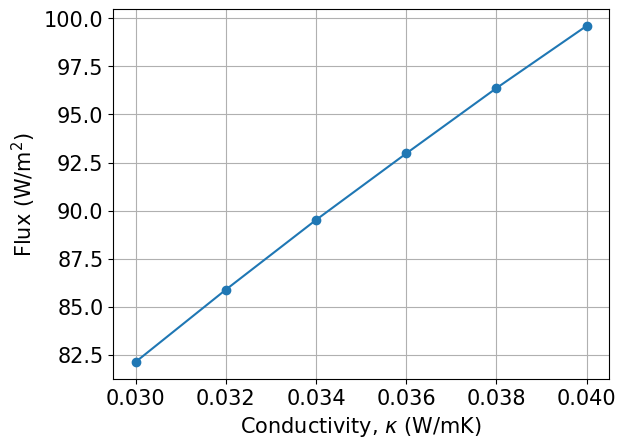

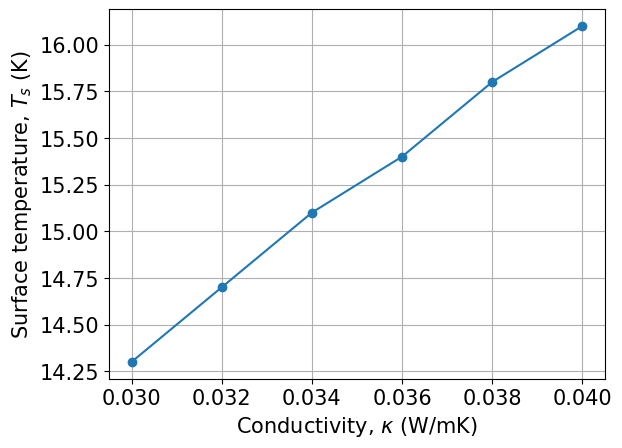

In [54]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams.update({'font.size': 15})
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

kappa_list = [0.03,0.032,0.034,0.036,0.038,0.04]
Ts_list = [14.3,14.7,15.1,15.4,15.8,16.1]
Flux = [82.12,85.88,89.51,92.97,96.37,99.61]

plt.plot(kappa_list, Flux, "-o")
plt.xlabel(r"Conductivity, $\kappa$ (W/mK)")
plt.ylabel(r"Flux (W/m$^2$)")
plt.grid(True)
plt.show()


plt.plot(kappa_list, Ts_list, "-o")
plt.xlabel(r"Conductivity, $\kappa$ (W/mK)")
plt.ylabel(r"Surface temperature, $T_s$ (K)")
plt.grid(True)
plt.show()

### Exploring the Emissivity

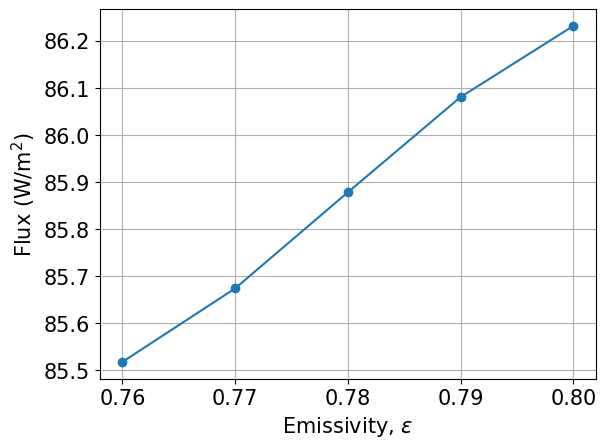

In [60]:
eps_list = [0.76, 0.77, 0.78, 0.79, 0.80]

Flux = [85.518, 85.674, 85.878, 86.080, 86.231]
plt.plot(eps_list, Flux, "-o")
plt.xlabel(r'Emissivity, $\epsilon$')
plt.ylabel(r"Flux (W/m$^2$)")
plt.grid(True)
plt.show()

In [8]:
Area_outer = Integrate(1, mesh, BND, definedon=mesh.Boundaries("bag"))
print(Area_outer)


0.14130321952319516


### Save result to paraview

In [9]:
vtk = VTKOutput(ma=mesh, coefs=[gfu], names=["temperature"], filename="../paraview/InfCyl7p5mm", subdivision=3)
vtk.Do()

'../paraview/InfCyl7p5mm'